# BT4012 Fraud Analytics Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from sknetwork.data import from_edge_list
from sknetwork.clustering import Louvain, get_modularity
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, make_scorer, average_precision_score
import folium as fo
import torch
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from IPython.display import SVG
from sknetwork.visualization import svg_bigraph


https://www.kaggle.com/code/badmangamingsv/credit-card-fraud-detection/notebook

^ Can reference from this and take this out before submission

## Importing Data

In [2]:
train = pd.read_csv("fraudTrain.csv", index_col=0)
test = pd.read_csv("fraudTest.csv", index_col=0)

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
print(train.info())

In [ ]:
print(test.info())

In [ ]:
train.describe().T

In [ ]:
numerical_variables = ["cc_num", "amt", "zip", "lat", "long", "city_pop","unix_time", "merch_lat", "merch_long", "is_fraud"]
cat_variables = ["merchant", "category", "first", "last", "gender", "street", "city", "state", "job","dob","trans_num"]
unique_counts = {}
for variable in cat_variables:
    unique_count = train[variable].nunique()
    unique_counts[variable] = unique_count

# Output the count of unique values for each categorical variable
for variable, count in unique_counts.items():
    print(f"There are {count:,} unique values in the '{variable}' column.")

# Exploratory Data Analysis

In [ ]:
ratio = train["is_fraud"].value_counts() / len(train) *100
ratio

bar_plot = plt.bar(ratio.index, ratio.values)
plt.xlabel("Value")
plt.ylabel("Percentage")
plt.title("Percentage of non-fraud vs fraud")
plt.xticks(ratio.index, labels=["Non-Fraud (0)", "Fraud (1)"])

# Display the ratio on top of the bars
for bar, value in zip(bar_plot, ratio.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.1f}", ha="center", va="bottom")

plt.show()

From the above graph, it is obvious that there is an imbalance in the target variable with more than 99% of it being non-fraud.

## Check `gender` Distribution

In [ ]:
sns.countplot(data=train, x='gender')
plt.title('Distribution of Gender')
plt.show()

## Check `amt` Distribution

In [ ]:
sns.kdeplot(data=train["amt"]).set(title="Amount Distribution")

It seems like there are extreme values (or potential outliers) present in `amt`. The graph below shows the distribution of `amt` for up to the 95<sup>th</sup> percentile.

In [ ]:
quantile_95 = train["amt"].quantile(0.95)
filtered_data = train[train["amt"] <= quantile_95]["amt"]
sns.kdeplot(filtered_data).set(title="Amount Distribution (95th Percentile)")

## Check Distribution of `amt` Against Fraud Class

In [ ]:
fig, ax = plt.subplots()

sns.kdeplot(train[train["is_fraud"]==1]["amt"], fill=True, color="blue", label="Fraudulent", ax=ax)
sns.kdeplot(train[train["is_fraud"]==0]["amt"], fill=True, color="green", label="Normal", ax=ax)

ax.set_xlabel("Transaction Amount")
ax.set_ylabel("Density")

ax.set_xlim(-500,2000)

fig.suptitle("Amount vs Fraud Class")
plt.legend()

Typically, legitimate transactions are approximately $200 or lower, whereas fraudulent transactions often spike near $300 and again between $800 and $1000. This demonstrates a distinct trend.

In [ ]:
cities_fraud = pd.DataFrame(train[train["is_fraud"] == 1].state.value_counts().to_frame('count'))
cities_non = pd.DataFrame(train[train["is_fraud"] == 0].state.value_counts().to_frame('count'))
cities = cities_fraud.join(cities_non, lsuffix="_fraud", rsuffix="_non_fraud")
cities.count_non_fraud = cities.count_non_fraud.fillna(0).apply(lambda x: int(x))
cities["fraud_proportion"] = round(cities.count_fraud   / (cities.count_fraud   + cities.count_non_fraud), 10)
cities = cities.sort_values(by="fraud_proportion", ascending=False)

In [ ]:
cities

In [ ]:
cities.reset_index().rename(columns={'index': 'state'}).head(10)

In [ ]:
# Filter only top 10 based on fraud proportion
cities_filtered = cities.head(10).reset_index().rename(columns={'index': 'state'}).sort_values(by="fraud_proportion", ascending=True)
plt.barh(cities_filtered.state, cities_filtered.fraud_proportion)
plt.xlabel("Proportion of fraud cases")
plt.ylabel("State")
plt.title("Top 10 States by Fraud Proportion")

The above graph shows the top 10 states based on fraud proportion. Interestingly, state DE (Delaware) has 9 transactions that occurred and all of them were fraudulent.

## Check Location Of Merchants Where Fraudulent Transactions Occurred

In [ ]:
map = fo.Map(location=[45.50, -100.75], zoom_start=5)

In [ ]:
filtered_geo_data = train[train["is_fraud"] == 1]
points = filtered_geo_data[["merch_lat", "merch_long"]].apply(tuple, axis=1)
for point in points:
    fo.CircleMarker(location=[point[0], point[1]], fill_color="red", fill=True, radius=5).add_to(map)
map

The graph above shows the distribution of fraudulent transactions in the United States. It seems that there are more fraudulent transactions in the eastern side of the United States than central and western United States.

## Quantile Analysis

In [ ]:
quantile = train[numerical_variables].describe().loc[['min', '25%', '50%', '75%', 'max']].transpose()
quantile.columns = ['min', 'Q1', 'Q2', 'Q3', 'max']
quantile['range'] = quantile['max'] - quantile['min']
quantile['IQR'] = quantile['Q3'] - quantile['Q1']
quantile.drop(["cc_num", "zip", "lat", "long", "unix_time", "merch_lat", "merch_long"], axis=0)

In [ ]:
quantile = train[numerical_variables].describe().loc[['min', '25%', '50%', '75%', 'max']].transpose()
quantile.columns = ['min', 'Q1', 'Q2', 'Q3', 'max']
quantile['range'] = quantile['max'] - quantile['min']
quantile['IQR'] = quantile['Q3'] - quantile['Q1']
quantile.drop(["cc_num", "zip", "lat", "long", "unix_time", "merch_lat", "merch_long"], axis=0)

In [ ]:
descriptive_stats = train[numerical_variables].describe().loc[['mean', 'std', '50%']].transpose()
descriptive_stats.columns = ['mean', 'std', 'median']
descriptive_stats['mode'] = train[numerical_variables].mode().transpose()[0]
descriptive_stats['mad'] = [stats.median_abs_deviation(train[x]) for x in numerical_variables]
descriptive_stats['kurtosis'] = [stats.kurtosis(train[x]) for x in numerical_variables]
descriptive_stats['skewness'] = [stats.skew(train[x]) for x in numerical_variables]
descriptive_stats.drop(["cc_num", "zip", "lat", "long", "unix_time", "merch_lat", "merch_long"], axis=0)

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 16))

axes = ["amt", "city_pop", "is_fraud"]

for index, name in enumerate(train[axes].columns):
    if index < 3:
        axes[index] = axs[index]
        train[name].hist(ax=axes[index], bins=20)
        axes[index].set_title(name, fontsize=16)

plt.tight_layout()
plt.show()

## Check `category` Distribution

In [ ]:
# sort train data by category
ax = sns.countplot(x="category", data=train, order=train.category.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Number of Transactions Based on Category")

From the above graph, the top 5 categories based on number of transactions are gas_transport, grocery_pos, home, shopping_pos and kids_pets.

## Check Proportion of Fraudulent Transactions Per `category`

In [ ]:
#calculate the percentage difference
a=train[train['is_fraud']==0]['category'].value_counts(normalize=True).to_frame().reset_index()
a.columns=['category','not fraud percentage']

b=train[train['is_fraud']==1]['category'].value_counts(normalize=True).to_frame().reset_index()
b.columns=['category','fraud percentage']
ab=a.merge(b,on='category')
ab['diff']=ab['fraud percentage']-ab['not fraud percentage']

ax=sns.barplot(y='category',x='diff',data=ab.sort_values('diff',ascending=False))
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('The Percentage Difference of Fraudulent over Non-Fraudulent Transations in Each Spending Category ')

Certain categories of spending are more susceptible to fraud, particularly 'Shopping_net', 'Grocery_pos', and 'misc_net'. Conversely, categories such as 'home' and 'kids_pets' generally experience higher volumes of legitimate transactions compared to fraudulent activity.

In [ ]:
# sort fraudulent and non-fraudulent train data by category
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train_fraudulent = train[train["is_fraud"] == 1]
train_non_fraudulent = train[train["is_fraud"] == 0]

ax_fraudulent = sns.countplot(x="category", data=train_fraudulent, ax=axes[0])
ax_fraudulent.set_xticklabels(ax_fraudulent.get_xticklabels(), rotation=90)
axes[0].set_title("Fraudulent Transactions")

ax_non_fraudulent = sns.countplot(x="category", data=train_non_fraudulent, ax=axes[1])
ax_non_fraudulent.set_xticklabels(ax_non_fraudulent.get_xticklabels(), rotation=90)
axes[1].set_title("Non-Fraudulent Transactions")

#ax_non_fraudulent_without_outliers = sns.countplot(x="category", data=train_non_fraudulent_without_outliers, ax=axes[2])
#ax_non_fraudulent_without_outliers.set_xticklabels(ax.get_xticklabels(), rotation=90) 



From the above countplots we can see that among fraudulent transactions, gas_transport and travel have much higher occurrences compared to the other categories.

# Data Preprocessing

## Encoding of Categorical Variables

In [5]:
#KIV
numerical_variables = ["amt", "lat", "long", "city_pop", "unix_time", "merch_lat", "merch_long", "age", "transaction_hour", 
                       "transaction_day_of_week", "transaction_month", "is_fraud"]
cat_variables = ["category", "gender"]
not_useful = ["trans_date_trans_time", "cc_num", "zip", "trans_num", "street", "dob", "first", "last", "merchant", "city", "job", "state", "transaction_dt"]

train_graph = train
test_graph = test

train = train.drop(train[not_useful], axis=1)
test = test.drop(test[not_useful], axis=1)

for category in cat_variables:
    encoded = pd.get_dummies(train[category], drop_first=True)
    test_encoded = pd.get_dummies(test[category], drop_first=True)
    train = pd.concat([train.drop([category], axis=1),encoded], axis=1)
    test = pd.concat([test.drop([category], axis=1),test_encoded], axis=1)

In [6]:
with pd.option_context('display.max_rows', None):
  print(train.dtypes)
train.describe()
train.columns = train.columns.astype(str)


amt                        float64
lat                        float64
long                       float64
city_pop                     int64
unix_time                    int64
merch_lat                  float64
merch_long                 float64
is_fraud                     int64
transaction_hour             int64
transaction_day_of_week      int64
transaction_month            int64
age                          int64
food_dining                  uint8
gas_transport                uint8
grocery_net                  uint8
grocery_pos                  uint8
health_fitness               uint8
home                         uint8
kids_pets                    uint8
misc_net                     uint8
misc_pos                     uint8
personal_care                uint8
shopping_net                 uint8
shopping_pos                 uint8
travel                       uint8
M                            uint8
dtype: object


# Feature Engineering

In [3]:
train["transaction_dt"] = pd.to_datetime(train["trans_date_trans_time"])
test["transaction_dt"] = pd.to_datetime(test["trans_date_trans_time"])

# Extract the hour in which the transaction was made (0=midnight, 23=11p.m.)
train["transaction_hour"] = train["transaction_dt"].dt.hour
test["transaction_hour"] = test["transaction_dt"].dt.hour

# Extract the day of the week in which the transaction was made (Monday=0, Sunday=6)
train['transaction_day_of_week'] = train['transaction_dt'].dt.day_of_week
test['transaction_day_of_week'] = test['transaction_dt'].dt.day_of_week

# Extract the month in which the transaction was made (January=1, December=12)
train['transaction_month'] = train['transaction_dt'].dt.month
test['transaction_month'] = test['transaction_dt'].dt.month

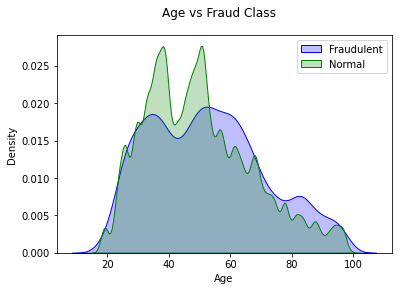

In [4]:
current_year = datetime.now().year
train['dob'] = pd.to_datetime(train['dob'])
train['age'] = current_year - train['dob'].dt.year
test['dob'] = pd.to_datetime(test['dob'])
test['age'] = current_year - test['dob'].dt.year


fig, ax = plt.subplots()

sns.kdeplot(train[train["is_fraud"]==1]["age"], fill=True, color="blue", label="Fraudulent", ax=ax)
sns.kdeplot(train[train["is_fraud"]==0]["age"], fill=True, color="green", label="Normal", ax=ax)

ax.set_xlabel("Age")
ax.set_ylabel("Density")

fig.suptitle("Age vs Fraud Class")
plt.legend()

In [ ]:
dims=(20,10)
fig,ax = plt.subplots(figsize = dims)
ax=sns.histplot(data=train, x="transaction_hour", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage of Transactions', fontsize=12)
ax.set_xlabel('Hour of the Day', fontsize=12)
ax.set_title('Percentage of Fraudulent vs Non-Fraudulent Transactions by Hour', fontsize=14)

plt.xticks(np.arange(0,24,1))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])
# plt.show()

In [ ]:
# Calculate the fraud rate
fraud_rate = (train[train['is_fraud'] == 1].groupby('transaction_day_of_week').size() /
              train.groupby('transaction_day_of_week').size())

# Convert to DataFrame for plotting
fraud_rate = fraud_rate.reset_index(name='fraud_rate')

days_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
            4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Apply the mapping to your 'transaction_day_of_week' column
fraud_rate['transaction_day_of_week'] = fraud_rate['transaction_day_of_week'].map(days_map)

# Plot the fraud rates by day of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(14, 6))
sns.barplot(x='transaction_day_of_week', y='fraud_rate', data=fraud_rate, order=days_order)
plt.title('Fraud Rate by Day of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Fraud Rate')
plt.show()


## Splitting to Train and Validation

In [7]:
split_index = int(0.9 * len(train))
train_set = train.iloc[:split_index, :]
validation_set = train.iloc[split_index:, :]

validation_set.head()

,amt,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,transaction_hour,transaction_day_of_week,...,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel,M
1167007,87.66,48.8878,-118.2105,149,1367492969,48.777202,-118.972455,0,11,5,...,0,0,0,0,0,0,0,0,0,0
1167008,55.22,39.6704,-89.8588,1213,1367493022,39.846241,-89.469599,0,11,5,...,0,0,0,0,0,0,0,0,0,0
1167009,46.51,42.6315,-75.1866,165,1367493029,42.364697,-75.843485,0,11,5,...,0,0,0,0,0,0,0,0,0,0
1167010,58.93,43.4987,-90.2796,1360,1367493045,44.053594,-91.031229,0,11,5,...,0,0,0,0,0,0,0,0,0,1
1167011,37.11,44.6723,-103.8396,8007,1367493077,45.401825,-103.544921,0,11,5,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1167007 entries, 0 to 1167006
Data columns (total 26 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   amt                      1167007 non-null  float64
 1   lat                      1167007 non-null  float64
 2   long                     1167007 non-null  float64
 3   city_pop                 1167007 non-null  int64  
 4   unix_time                1167007 non-null  int64  
 5   merch_lat                1167007 non-null  float64
 6   merch_long               1167007 non-null  float64
 7   is_fraud                 1167007 non-null  int64  
 8   transaction_hour         1167007 non-null  int64  
 9   transaction_day_of_week  1167007 non-null  int64  
 10  transaction_month        1167007 non-null  int64  
 11  age                      1167007 non-null  int64  
 12  food_dining              1167007 non-null  uint8  
 13  gas_transport            1167007 non-null 

In [ ]:
validation_set.info()

In [ ]:
test.info()

### Feature Selection using RandomForestClassifier

In [ ]:
# Select columns
"""
------------------------ Original Columns -------------------

numerical_variables = ["amt", "lat", "long", "city_pop","unix_time", "merch_lat", "merch_long", "is_fraud"]

-------------------------To be Encoded---------------------

cat_variables = ["merchant", "category", "gender", "city", "state", "job"] 
not_useful = ["trans_date_trans_num", "cc_num", "trans_num", "street", "dob", "first", "last"]
"""
#selected_columns = ["amt", "lat", "long", "city_pop", "unix_time", "merch_lat", "merch_long", "is_fraud", 
#                    "transaction_hour", "transaction_day_of_week", "transaction_month"]

# Create a new DataFrame with selected columns
#df_selected = train_set[selected_columns]
df_selected = train_set
# Encode categorical variables if needed (use pd.get_dummies if necessary)

# Split the data into features (X) and target variable (y)
X = df_selected.drop("is_fraud", axis=1)
y = df_selected["is_fraud"]

# Initialize a random forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X, y)

# Plot the variable importance
feature_importance = model.feature_importances_
feature_names = X.columns
data={'Feature': feature_names, 'Importance': feature_importance}
fi_df = pd.DataFrame(data)

fi_df = fi_df.sort_values(by=['Importance'], ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(fi_df['Feature'], fi_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Variable Importance Plot')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Drop the columns from the training set
X_train_log = train_set.drop("is_fraud", axis=1)
y_train_log = train_set['is_fraud']

# Drop the columns from the test set
X_test_log = test.drop("is_fraud", axis=1)
y_test_log = test['is_fraud']

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Fit the model on the training data
log_reg.fit(X_train_log, y_train_log)

# Predict on the test set
y_pred_log = log_reg.predict(X_test_log)

# Evaluate the model's performance
print(classification_report(y_test_log, y_pred_log))


In [ ]:
# Further evaluation
# Calculate evaluation metrics on test data
lg_accuracy = accuracy_score(y_test_log, y_pred_log)

# Print evaluation metrics with 3 decimal places, multiplied by 100
print("Logistic Regression Accuracy: {:.3f}%".format(lg_accuracy * 100))

The Logistic Regression is not a good model.

In [ ]:
# Calculate ROC curve and AUC
probs = log_reg.predict_proba(X_test_log)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_log, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test_log, y_pred_log)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Didnt predict any frauds LOL (updated: donez)

In [ ]:
# Drop the columns from the training set
X_train_tree = train_set.drop('is_fraud', axis=1)
y_train_tree = train_set['is_fraud']

# Drop the columns from the test set
X_test_tree = test.drop('is_fraud', axis=1)
y_test_tree = test['is_fraud']

# Initialize the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Fit the model on the training data
decision_tree.fit(X_train_tree, y_train_tree)

# Predict on the test set
y_pred_tree = decision_tree.predict(X_test_tree)

# Evaluate the model's performance
print(classification_report(y_test_tree, y_pred_tree))


In [ ]:
# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Fit the model on the training data
random_forest.fit(X_train_tree, y_train_tree)

# Predict on the test set
y_pred_rf = random_forest.predict(X_test_tree)

# Evaluate the model's performance
print(classification_report(y_test_tree, y_pred_rf))


In [ ]:
# Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
gradient_boosting.fit(X_train_tree, y_train_tree)

# Predict on the test set
y_pred_gb = gradient_boosting.predict(X_test_tree)

# Evaluate the model's performance
print(classification_report(y_test_tree, y_pred_gb))


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

In [ ]:
numerical_variables = ["amt", "lat", "long", "city_pop", "unix_time", "merch_lat", "merch_long", "transaction_hour", "transaction_day_of_week", "transaction_month"]

for i in numerical_variables:
    # fit on training data column
    scale = StandardScaler().fit(train_set[[i]])
    # transform the training data column
    train_set[i] = scale.transform(train_set[[i]])
    # transform the validation data column
    validation_set[i] = scale.transform(validation_set[[i]])
    #transform the test data column
    test[i] = scale.transform(test[[i]])

# Extract features and labels from the new dataset
X_train_num = train_set[numerical_variables]
X_train_cat = train_set.drop(numerical_variables, axis=1)
y_train = train_set["is_fraud"]

X_valid_num = validation_set[numerical_variables]
X_valid_cat = validation_set.drop(numerical_variables, axis=1)
y_valid = validation_set["is_fraud"]

bs = 50 #batch size
train_ds = torch.utils.data.TensorDataset(torch.tensor(X_train_num.values, dtype=torch.float32).float(), torch.tensor(X_train_cat.values,  dtype=torch.float32).float(), torch.tensor(y_train.values,  dtype=torch.float32).float())
valid_ds = torch.utils.data.TensorDataset(torch.tensor(X_valid_num.values,  dtype=torch.float32).float(), torch.tensor(X_valid_cat.values,  dtype=torch.float32).float(), torch.tensor(y_valid.values,  dtype=torch.float32).float())

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs)


class NumericalPrediction(nn.Module):
    def __init__(self):
        super(NumericalPrediction, self).__init__()
        self.num_layers = nn.Sequential(
            nn.Linear(len(numerical_variables), 64),  # Adjust input size based on the number of numerical features
            nn.ReLU())
        self.binary_layers = nn.Sequential(
            nn.Linear(len(X_train_cat.columns), 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU())
        self.drop_out = nn.Dropout(0.2)
        
        self.output_layer = nn.Linear(128,1)
        
    def forward(self, numerical_inputs, binary_inputs):
        numerical_outputs = self.num_layers(numerical_inputs)
        binary_outputs = self.binary_layers(binary_inputs)
        concatenated_outputs = torch.cat((numerical_outputs, binary_outputs), dim=1)
        final_outputs = self.drop_out(concatenated_outputs)
        final_outputs = self.output_layer(final_outputs)
        return final_outputs

# Instantiate the model
model = NumericalPrediction()


In [ ]:
activation_fn = torch.nn.ReLU()
model = NumericalPrediction()
#loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
pos_weight = torch.tensor([10])
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def loss_batch(model, loss_func, x_num, x_cat, yb, opt=None):
    #loss = loss_func(model(x_num, x_cat), yb)
    loss = loss_func(model(x_num, x_cat), yb.unsqueeze(1))

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x_num)

def train(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for x_num, x_cat, yb in train_dl:
            loss_batch(model, loss_func, x_num, x_cat, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, x_num, x_cat, yb) for x_num, x_cat, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        if epoch == (epochs-1):
            torch.save(model.state_dict(), 'nn_model4.pth')


n_input = X_train_num.shape[1]
n_output = 1
n_hidden = 10
n_epoch = 10

In [ ]:
train(n_epoch, model, loss_fn, optimizer, train_dl, valid_dl)

In [ ]:
X_test_num = test[numerical_variables]
X_test_cat = test.drop(numerical_variables, axis=1)
y_test = test["is_fraud"]

ypred = model(torch.tensor(X_test_num.values).float(), torch.tensor(X_test_cat.values).float())
ypred = (ypred >= 0.5).float().numpy()
print('Confusion matrix: {}')
conf_matrix = confusion_matrix(y_test, ypred)
print(conf_matrix)
print('AUROC score: {}'.format(roc_auc_score(y_test, ypred)))
print('Accuracy score: {}'.format(accuracy_score(y_test, ypred)))
print(classification_report(y_test, ypred))

# Graph Model

In [9]:
full_dataset = pd.concat([train_graph, test_graph]).reset_index(drop=True)

In [10]:
txg = pd.melt(full_dataset, id_vars=['cc_num'], value_vars=['category', 'state', 'job'])
txg['TOKEN'] = txg['variable'].astype(str) + "_" + txg["value"].astype(str)
txg = txg[['cc_num', 'TOKEN']].groupby(['cc_num', 'TOKEN']).size().reset_index(name='TF')

# Calculate IDF for each cc_num
usg = txg[['cc_num', 'TOKEN']].groupby(['cc_num']).size().reset_index(name='IDF')

# Calculate TF-IDF for each cc_num and TOKEN combination
txg = txg.merge(usg, on='cc_num')
txg['TF_IDF'] = txg['TF'] / txg['IDF']

# Convert the cc_num and TOKEN combinations into an edge list
edge_list = list(txg.itertuples(index=False))
graph = from_edge_list(edge_list, bipartite=True)

# Extract biadjacency matrix and names
biadjacency = graph.biadjacency
names_row = graph.names_row
names_col = graph.names_col

# Apply the Louvain algorithm
louvain = Louvain(resolution=1.7, modularity='newman')
louvain.fit(biadjacency)

# Extract labels
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_

# Calculate and print modularity
print(get_modularity(biadjacency, labels_row, labels_col))

# Aggregate the graph
biadjacency_aggregate = louvain.aggregate_

# Get unique labels and their counts for rows and columns
labels_unique_row, counts_row = np.unique(labels_row, return_counts=True)
labels_unique_col, counts_col = np.unique(labels_col, return_counts=True)

0.08851268739572865


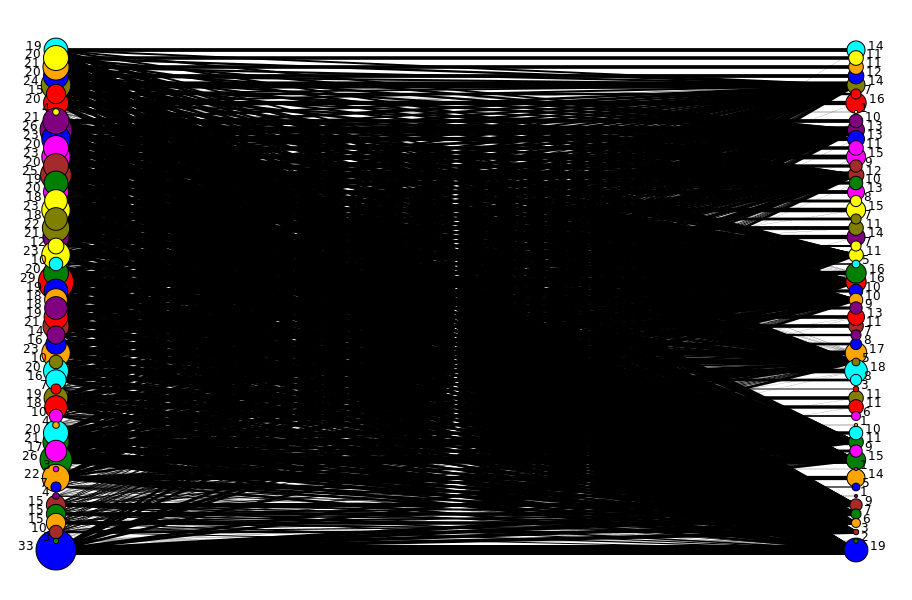

In [11]:
from IPython.display import SVG
from sknetwork.visualization import svg_bigraph
image = svg_bigraph(biadjacency_aggregate, counts_row, counts_col, labels_unique_row, labels_unique_col,
                    display_node_weight=True, node_weights_row=counts_row, node_weights_col=counts_col,
                    scale=0.5, height=1000, width=1600, reorder=True, edge_width_min = 0.0001, margin= 100)
SVG(image)

In [12]:
# Create a dictionary mapping cc_num to Louvain community labels
louv_dict = {name: label for name, label in zip(names_row, labels_row)}
louv_dict = {int(k): v for k, v in louv_dict.items()}

# Louvain community mapping
train_graph['louvain_community'] = train_graph['cc_num'].map(louv_dict)
test_graph['louvain_community'] = test_graph['cc_num'].map(louv_dict)

# Splitting to validation
split_index = int(0.9 * len(train_graph))
train_set = train_graph.iloc[:split_index, :]
validation_set = train_graph.iloc[split_index:, :]

In [13]:
def display_importances_xgb(model, use_features):
    fmap = {'f'+ str(index): x for index, x in enumerate(use_features, start=0)}
    fimp_df = pd.DataFrame(list(model.get_booster().get_fscore().items()))
    fimp_df.columns = ['feature', 'importance']
    fimp_df['importance']=fimp_df['importance']/np.sum(fimp_df['importance'])
    fimp_df['feature'] = fimp_df['feature'].map(fmap)

    plt.figure(figsize=(14, 10))
    sns.barplot(x="importance", y="feature", data=fimp_df.sort_values(by="importance", ascending=False))
    plt.title('Feature Importance')
    plt.tight_layout()

In [14]:

all_columns_to_drop = [
    'trans_date_trans_time', 'cc_num', 'first', 'last', 'street',
    'merchant', 'city', 'job', 'dob', 'transaction_dt', 'lat', 'long',
    'merch_lat', 'merch_long', 'zip',
]

# Drop the columns and separate the target
y_train = train_set['is_fraud']
X_train = train_set.drop(columns=all_columns_to_drop + ['is_fraud'], axis=1, errors='ignore')

y_validation = validation_set['is_fraud']
X_validation = validation_set.drop(columns=all_columns_to_drop + ['is_fraud'], axis=1, errors='ignore')


y_test = test_graph['is_fraud']
X_test = test_graph.drop(columns=all_columns_to_drop + ['is_fraud'], axis=1, errors='ignore')

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features_to_impute = [col for col in numeric_features if col != 'louvain_community']
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Define transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_to_impute),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')

In [24]:

# Initialize the XGBClassifier with initial hyperparameters
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

xgb_clf = XGBClassifier(
    nthread=-1, n_estimators=100, learning_rate=0.1,
    objective='binary:logistic', max_depth=2,
    scale_pos_weight=scale_pos_weight, min_child_weight=50,
    gamma=10, max_delta_step=2
)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', xgb_clf)])

# Train the model on the DataFrame
pipeline.fit(X_train, y_train)

# Get the trained XGBClassifier
trained_model = pipeline.named_steps['model']

ROC-AUC score on the validation set: 0.9903855576230485
F1 score on the validation set: 0.23184601924759404
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    128836
           1       0.13      0.96      0.23       832

    accuracy                           0.96    129668
   macro avg       0.57      0.96      0.61    129668
weighted avg       0.99      0.96      0.97    129668

Confusion Matrix for the validation set:


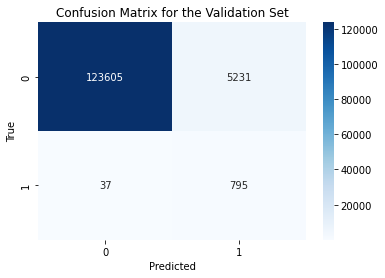

In [25]:
# Evaluate on the validation set
y_pred = pipeline.predict(X_validation)
y_pred_proba = pipeline.predict_proba(X_validation)[:, 1]

# Calculate ROC-AUC and F1 score
cm_validation = confusion_matrix(y_validation, y_pred)
roc_auc = roc_auc_score(y_validation, y_pred_proba)
f1 = f1_score(y_validation, y_pred)

print(f'ROC-AUC score on the validation set: {roc_auc}')
print(f'F1 score on the validation set: {f1}')
print(metrics.classification_report(y_validation, y_pred))
print("Confusion Matrix for the validation set:")
sns.heatmap(cm_validation, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for the Validation Set')
plt.show()

Confusion Matrix for the test set:
ROC-AUC score on the test set: 0.9869518993352483
F1 score on the test set: 0.14727497635159714
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    553574
           1       0.08      0.94      0.15      2145

    accuracy                           0.96    555719
   macro avg       0.54      0.95      0.56    555719
weighted avg       1.00      0.96      0.98    555719

Confusion Matrix for the test set:


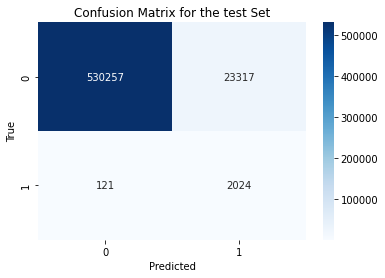

In [27]:
y_pred_test = pipeline.predict(X_test)
y_pred_proba_test = pipeline.predict_proba(X_test)[:, 1]

# Calculate the final ROC-AUC and F1 score for the test set
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
f1_test = f1_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print("Confusion Matrix for the test set:")
print(f'ROC-AUC score on the test set: {roc_auc_test}')
print(f'F1 score on the test set: {f1_test}')
print(classification_report(y_test, y_pred_test))
print("Confusion Matrix for the test set:")
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for the test Set')
plt.show()

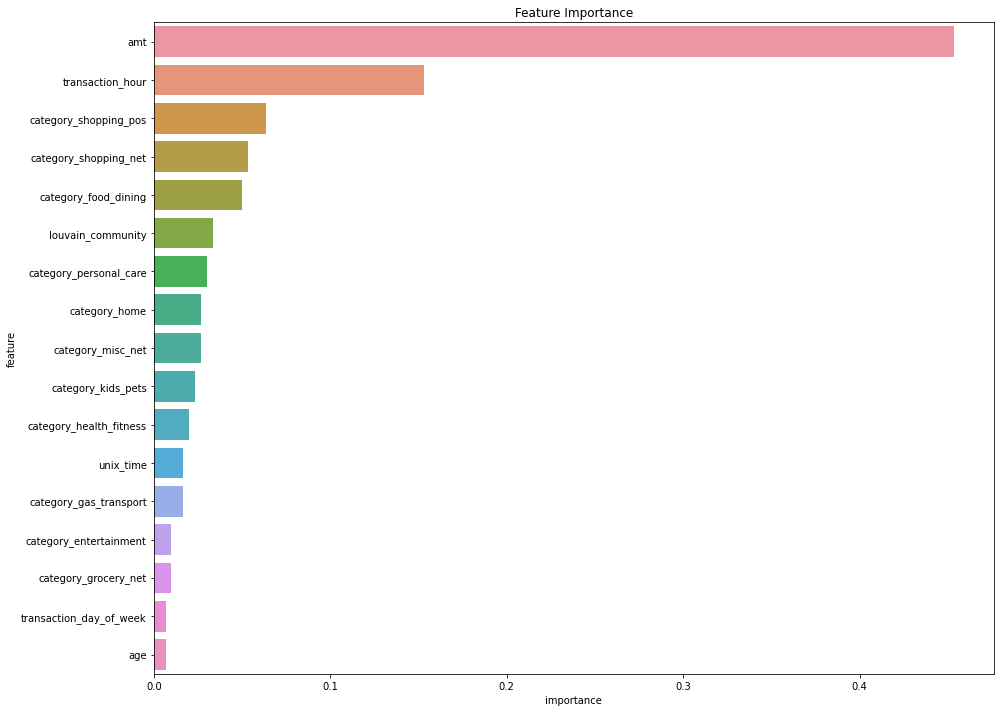

In [28]:
# Get feature names after one-hot encoding
ohe_feature_names = (pipeline.named_steps['preprocessor']
                            .named_transformers_['cat']
                            .named_steps['onehot']
                            .get_feature_names_out(categorical_features))

# Combine numeric and one-hot encoded feature names
features_after_preprocessing = np.append(numeric_features, ohe_feature_names)

# Display feature importances
display_importances_xgb(trained_model, features_after_preprocessing)

In [29]:
# Define a search space for hyperparameters
param_distributions = {
    'model__n_estimators': randint(50, 200),
    'model__learning_rate': uniform(0.01, 0.1),
    'model__max_depth': randint(3, 7),
    'model__min_child_weight': randint(1, 6),
    'model__gamma': uniform(0, 0.3),
    'model__max_delta_step': randint(0, 5),
    'model__scale_pos_weight': randint(1, 100)
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=5,
    scoring=make_scorer(average_precision_score),
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV to find the best hyperparameters
random_search.fit(X_train, y_train)

# Print the best parameters found
print(f'Best parameters found: {random_search.best_params_}')

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best parameters found: {'model__gamma': 0.013999698964084628, 'model__learning_rate': 0.10737555188414592, 'model__max_delta_step': 2, 'model__max_depth': 6, 'model__min_child_weight': 4, 'model__n_estimators': 113, 'model__scale_pos_weight': 3}


ROC-AUC score on the validation set with the best model: 0.9981236301159256
F1 score on the validation set with the best model: 0.8611825192802056
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    128836
           1       0.93      0.81      0.86       832

    accuracy                           1.00    129668
   macro avg       0.96      0.90      0.93    129668
weighted avg       1.00      1.00      1.00    129668

Confusion Matrix for the validation set:


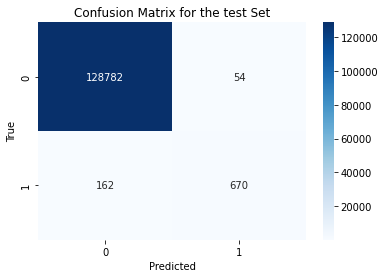

In [32]:
# Evaluate the best model found on the validation set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_validation)
y_pred_proba = best_model.predict_proba(X_validation)[:, 1]

# Calculate ROC-AUC and F1 score with the best model
roc_auc = roc_auc_score(y_validation, y_pred_proba)
f1 = f1_score(y_validation, y_pred)
cm_validation = confusion_matrix(y_validation, y_pred)



print(f'ROC-AUC score on the validation set with the best model: {roc_auc}')
print(f'F1 score on the validation set with the best model: {f1}')
print(classification_report(y_validation, y_pred))
print("Confusion Matrix for the validation set:")
sns.heatmap(cm_validation, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for the test Set')
plt.show()


Final ROC-AUC score on the test set: 0.9964834209820427
Final F1 score on the test set: 0.8341633466135459
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.90      0.78      0.83      2145

    accuracy                           1.00    555719
   macro avg       0.95      0.89      0.92    555719
weighted avg       1.00      1.00      1.00    555719

Confusion Matrix for the test set:


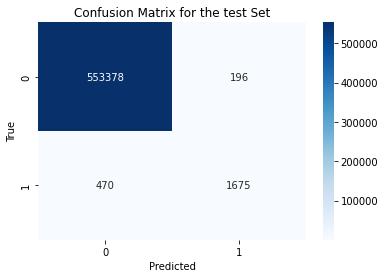

In [34]:
y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

# Calculate the final ROC-AUC and F1 score for the test set
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
f1_test = f1_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f'Final ROC-AUC score on the test set: {roc_auc_test}')
print(f'Final F1 score on the test set: {f1_test}')
print(classification_report(y_test, y_pred_test))
print("Confusion Matrix for the test set:")
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for the test Set')
plt.show()